<a href="https://colab.research.google.com/github/oyane806/lets-stop-wildfires-hackathon/blob/master/wildfire_smoke_challenge_1A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
import tarfile

In [0]:
bs = 64

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# 1. Load data

In [6]:
!wget https://www.dropbox.com/s/ghfhjtoh1z59xeb/wildfire_smoke_data.tar

--2020-01-10 05:54:05--  https://www.dropbox.com/s/ghfhjtoh1z59xeb/wildfire_smoke_data.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ghfhjtoh1z59xeb/wildfire_smoke_data.tar [following]
--2020-01-10 05:54:06--  https://www.dropbox.com/s/raw/ghfhjtoh1z59xeb/wildfire_smoke_data.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc195f127dd4699c537c87b6a127.dl.dropboxusercontent.com/cd/0/inline/Av79PbAimZGQD6ri-JErYaZOhwx9FnNa3qyrtkepQDuXty3SlsHJ59pj1cFvfFE6EnFyonEu2IQop2UrbegDX0tUv7vftRwZOjr9Y-joEZliaD_ybHU9Kp_5tQ2J6VpJyuE/file# [following]
--2020-01-10 05:54:06--  https://uc195f127dd4699c537c87b6a127.dl.dropboxusercontent.com/cd/0/inline/Av79PbAimZGQD6ri-JErYaZOhwx9FnNa3qyrtkepQDuXty3SlsHJ59pj1cFvfFE6EnFyonEu2IQop2Urb

In [0]:
tarred_file = tarfile.open("wildfire_smoke_data.tar")
tarred_file.extractall()
tarred_file.close()

In [0]:
data = ImageDataBunch.from_folder("wildfire_smoke_data",
                                  train = 'train',
                                  valid='validate',
                                  ds_tfms=get_transforms(), 
                                  size=224, bs=bs).normalize(imagenet_stats)

Be careful! Need to be in the right directory before using ImageDataBunch.

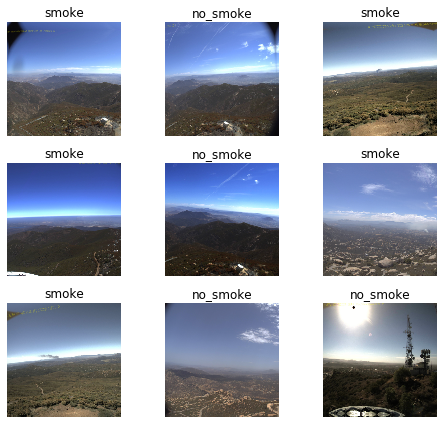

In [9]:
data.show_batch(rows=3, figsize=(7, 6))

It is difficult for human as well to detect smoke in some of those pictures.

# 2. Quick resnet model with pretrained weights



In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 291MB/s]


In [11]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.121604,0.802998,0.394737,02:14
1,1.101221,0.656940,0.327068,02:14
2,0.985341,0.548009,0.293233,02:15
3,0.886049,0.581022,0.312030,02:16
4,0.825423,0.521413,0.270677,02:18
5,0.767891,0.506024,0.240602,02:17


In [14]:
learn.save("/content/gdrive/My Drive/fastai/wildfires/stage-2", return_path=True)

PosixPath('/content/gdrive/My Drive/fastai/wildfires/stage-2.pth')

In [15]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.533200,0.425761,0.206767,02:13
1,0.502046,0.464284,0.263158,02:14
2,0.513003,0.444964,0.236842,02:14
3,0.511330,0.416001,0.218045,02:13
4,0.507338,0.368559,0.154135,02:14
5,0.498324,0.364754,0.154135,02:13


In [16]:
learn.save("/content/gdrive/My Drive/fastai/wildfires/stage-3", return_path=True)

PosixPath('/content/gdrive/My Drive/fastai/wildfires/stage-3.pth')

In [0]:
learn.load("/content/gdrive/My Drive/fastai/wildfires/stage-3")

In [11]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.492202,0.369602,0.169173,02:12
1,0.497834,0.442211,0.199248,02:12
2,0.489557,0.372321,0.172932,02:13
3,0.491269,0.352145,0.142857,02:12
4,0.478039,0.317112,0.154135,02:12
5,0.456579,0.317407,0.127820,02:12


In [12]:
learn.save("/content/gdrive/My Drive/fastai/wildfires/stage-4", return_path=True)

PosixPath('/content/gdrive/My Drive/fastai/wildfires/stage-4.pth')

In [13]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.441512,0.326792,0.150376,02:12
1,0.435648,0.344011,0.139098,02:14
2,0.437913,0.352666,0.157895,02:18
3,0.447157,0.332127,0.150376,02:20
4,0.435336,0.355865,0.142857,02:16
5,0.431767,0.346329,0.146617,02:16


In [14]:
learn.save("/content/gdrive/My Drive/fastai/wildfires/stage-5", return_path=True)

PosixPath('/content/gdrive/My Drive/fastai/wildfires/stage-5.pth')

## 👉 Results

The train_loss is not improving anymore and is still bigger than the validation_loss. It means that we are still underfitting. We should unfreeze layers and train again with a smaller learning rate.

I think that I should have increased the learning rate and/or decreased the batch-size to train faster.

# 3. Resnet model unfreezed

Let's first find the best learning rate.

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


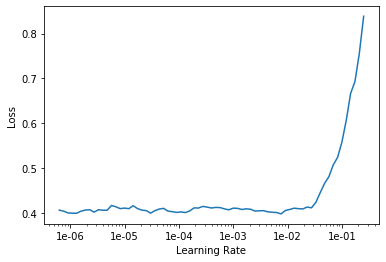

In [16]:
learn.recorder.plot()

It seems that the best learning rate for the last layers is around 0.01.

In [17]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.424150,0.716681,0.229323,02:14
1,0.527856,0.925016,0.244361,02:13
2,0.511513,0.346571,0.154135,02:15
3,0.459533,0.425745,0.176692,02:15
4,0.398714,0.396695,0.142857,02:15


In [0]:
learn.save("/content/gdrive/My Drive/fastai/wildfires/stage-6-unfreezed")

In [19]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-5,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.400117,0.412590,0.225564,02:13
1,0.372651,0.483211,0.150376,02:15
2,0.329684,0.409813,0.131579,02:14


In [0]:
learn.save("/content/gdrive/My Drive/fastai/wildfires/stage-7-unfreezed")

In [22]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.263952,0.392732,0.131579,02:16
1,0.245044,0.363207,0.127820,02:14
2,0.236860,0.342675,0.124060,02:16


In [0]:
learn.save("/content/gdrive/My Drive/fastai/wildfires/stage-8-unfreezed")

## 👉 Results

The train_loss is smaller than the valid_loss, we are not underfitting anymore. I think that we should train again for a few more epochs.

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

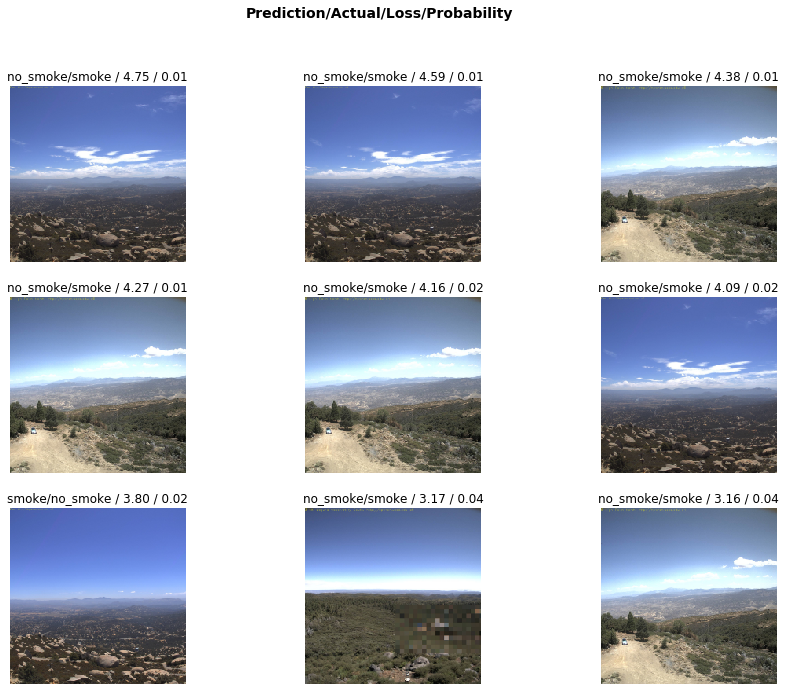

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

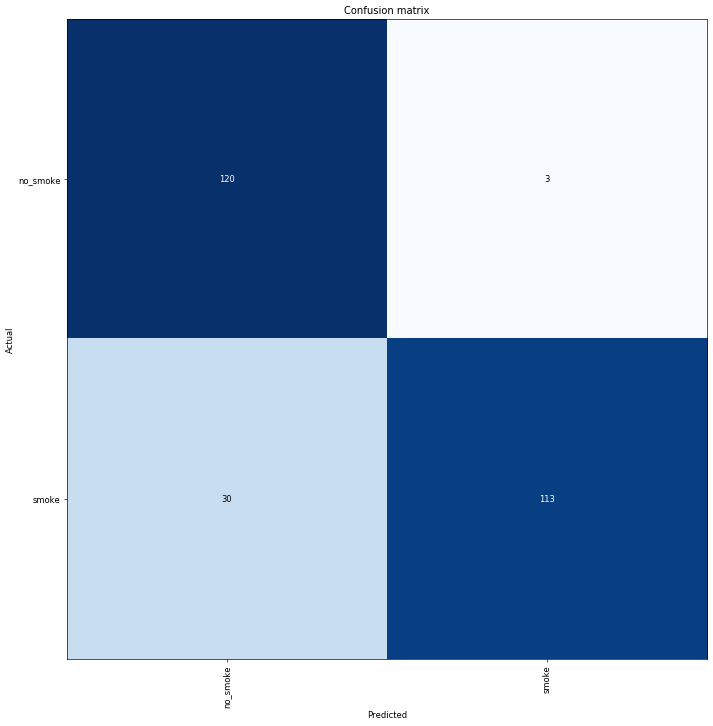

In [26]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

This confusion matrix is quite bad. We would prefer to predict smoke when there is no smoke, insted of predicting no smoke when there is actually a real fire.